# Financial Articles Vector Database Walkthrough

This notebook demonstrates how to use the vector database functionality to process financial articles about AAPL stock and create a searchable vector database using ChromaDB and sentence-transformers.

## Prerequisites

Before starting, make sure you have installed all necessary packages:

In [1]:
# Install required packages
# !pip install chromadb sentence-transformers langchain pandas

## 1. Import Libraries and Setup

First, let's import our custom vector_db module and other necessary libraries:

In [21]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the scripts directory to the Python path
scripts_dir = os.path.abspath('../scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

# Import our vector database utilities
import vector_db as vdb

# Set up visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Explore the Articles Dataset

Let's first examine the financial articles CSV file to understand its structure:

In [31]:
# Load the articles CSV
DATA_DIR = '../data/stock_portfolios'
articles_path = f'{DATA_DIR}/articles.csv'
articles_df = pd.read_csv(articles_path)

# Display the first few rows
articles_df.head(2)

,article_id,pubDate,pubDateTZ,title,link,creator,description,source_id,source_name,source_url,source_icon,summary,text
0,3b9e54e82ce177819af51c87c7473262,2025-05-16 18:53:39,UTC,Apple Stock: President Trump Had A Point In Qa...,https://seekingalpha.com/article/4787688-apple...,NaN,NaN,seekingalpha,Seeking Alpha,https://seekingalpha.com,https://i.bytvi.com/domain_icons/seekingalpha.png,NaN,NaN
1,bbbd1e44d96c98ab06769f13f6d697a0,2025-05-16 18:30:54,UTC,Analyst Lowers Target Q1 Forecast Amid Spendin...,https://www.benzinga.com/analyst-ratings/analy...,Nabaparna Bhattacharya,Telsey Advisory Group analyst Joseph Feldman r...,benzinga,Benzinga,https://www.benzinga.com,https://i.bytvi.com/domain_icons/benzinga.png,Telsey Advisory Group analyst Joseph Feldman r...,Telsey Advisory Group analyst Joseph Feldman r...


In [51]:
articles_df_cleaned =  articles_df[~articles_df['text'].isna()]

In [53]:
# Basic information about the dataset
print(f"Number of articles: {len(articles_df_cleaned)}")
print(f"\nColumns in the dataset:\n{articles_df_cleaned.columns.tolist()}")

# Check for missing values
missing_values = articles_df_cleaned.isnull().sum()
print(f"\nMissing values per column:\n{missing_values[missing_values > 0]}")

Number of articles: 202

Columns in the dataset:
['article_id', 'pubDate', 'pubDateTZ', 'title', 'link', 'creator', 'description', 'source_id', 'source_name', 'source_url', 'source_icon', 'summary', 'text']

Missing values per column:
creator        15
description    32
dtype: int64


In [76]:
print(articles_df_cleaned[articles_df_cleaned['text_length']>5000][['description','summary','text']].iloc[0]['summary'])

31 analysts have expressed a variety of opinions on Apple AAPL over the past quarter, offering a diverse set of opinions from bullish to bearish.
Deciphering Analyst Ratings: An In-Depth AnalysisIn examining recent analyst actions, we gain insights into how financial experts perceive Apple.
Responding to changing market dynamics and company performance, analysts update their recommendations.
With an impressive ROE of 37.11%, the company demonstrates effective use of equity capital and strong financial performance.
These specialists diligently analyze company financial statements, participate in conference calls, and engage with insiders to generate quarterly ratings for individual stocks.


In [61]:
print(articles_df_cleaned[articles_df_cleaned['text_length']>5000][['description','summary','text']].iloc[0]['text'])

31 analysts have expressed a variety of opinions on Apple AAPL over the past quarter, offering a diverse set of opinions from bullish to bearish.

The table below provides a snapshot of their recent ratings, showcasing how sentiments have evolved over the past 30 days and comparing them to the preceding months.

Bullish Somewhat Bullish Indifferent Somewhat Bearish Bearish Total Ratings 13 10 5 3 0 Last 30D 0 1 0 0 0 1M Ago 4 3 3 2 0 2M Ago 8 3 2 1 0 3M Ago 1 3 0 0 0

Analysts have recently evaluated Apple and provided 12-month price targets. The average target is $243.8, accompanied by a high estimate of $325.00 and a low estimate of $167.88. Highlighting a 4.41% decrease, the current average has fallen from the previous average price target of $255.05.

Deciphering Analyst Ratings: An In-Depth Analysis

In examining recent analyst actions, we gain insights into how financial experts perceive Apple. The following summary outlines key analysts, their recent evaluations, and adjustments

/Users/giannisalexandrou/tmp/ipykernel_39391/4204309800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df_cleaned['text_length'] = articles_df_cleaned['text'].str.len()


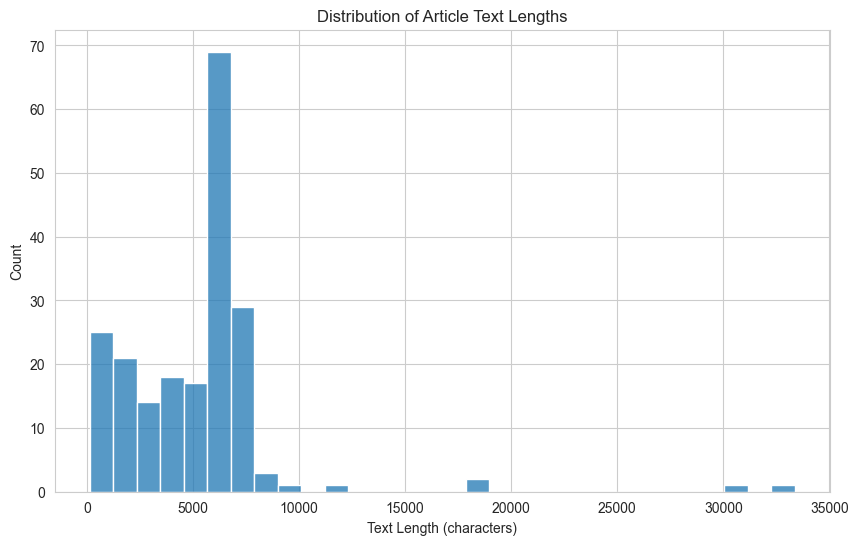

Average article length: 5129.22 characters
Median article length: 5778.00 characters
Min article length: 140.00 characters
Max article length: 33354.00 characters


In [54]:
# Analyze text length distribution
articles_df_cleaned['text_length'] = articles_df_cleaned['text'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(articles_df_cleaned['text_length'], bins=30)
plt.title('Distribution of Article Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.show()

print(f"Average article length: {articles_df_cleaned['text_length'].mean():.2f} characters")
print(f"Median article length: {articles_df_cleaned['text_length'].median():.2f} characters")
print(f"Min article length: {articles_df_cleaned['text_length'].min():.2f} characters")
print(f"Max article length: {articles_df_cleaned['text_length'].max():.2f} characters")

/Users/giannisalexandrou/tmp/ipykernel_39391/2222251399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df_cleaned['desc_length'] = articles_df_cleaned['description'].str.len()


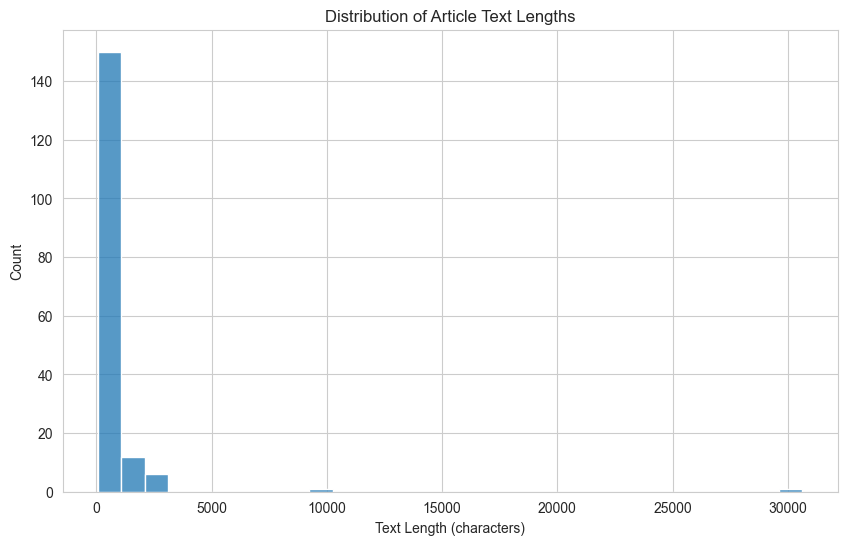

Average article length: 767.86 characters
Median article length: 359.00 characters
Min article length: 57.00 characters
Max article length: 30625.00 characters


In [70]:
# Analyze text length distribution
articles_df_cleaned['desc_length'] = articles_df_cleaned['description'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(articles_df_cleaned['desc_length'], bins=30)
plt.title('Distribution of Article Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.show()

print(f"Average article length: {articles_df_cleaned['desc_length'].mean():.2f} characters")
print(f"Median article length: {articles_df_cleaned['desc_length'].median():.2f} characters")
print(f"Min article length: {articles_df_cleaned['desc_length'].min():.2f} characters")
print(f"Max article length: {articles_df_cleaned['desc_length'].max():.2f} characters")

/Users/giannisalexandrou/tmp/ipykernel_39391/4065886904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df_cleaned['summary_length'] = articles_df_cleaned['summary'].str.len()


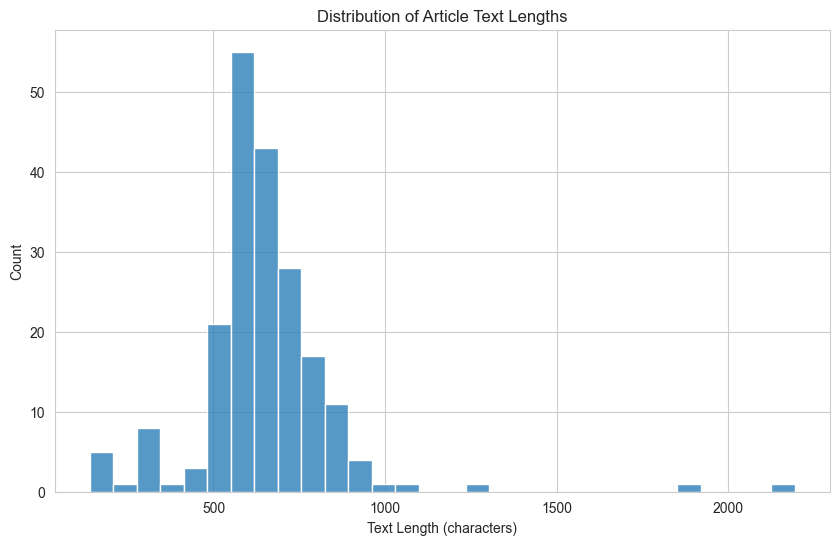

Average article length: 647.21 characters
Median article length: 628.00 characters
Min article length: 140.00 characters
Max article length: 2194.00 characters


In [75]:
# Analyze text length distribution
articles_df_cleaned['summary_length'] = articles_df_cleaned['summary'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(articles_df_cleaned['summary_length'], bins=30)
plt.title('Distribution of Article Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.show()

print(f"Average article length: {articles_df_cleaned['summary_length'].mean():.2f} characters")
print(f"Median article length: {articles_df_cleaned['summary_length'].median():.2f} characters")
print(f"Min article length: {articles_df_cleaned['summary_length'].min():.2f} characters")
print(f"Max article length: {articles_df_cleaned['summary_length'].max():.2f} characters")

## 3. Initialize the Embedding Model

Now, let's initialize the embedding model. We'll use the all-MiniLM-L6-v2 model from sentence-transformers, which provides a good balance between quality and efficiency for text embeddings.

In [78]:
# Initialize the embedding model
embedding_function = vdb.init_embedding_model()
print(f"Initialized embedding model: {vdb.DEFAULT_MODEL}")

Initialized embedding model: all-MiniLM-L6-v2


Let's test the embedding model on a sample text to see what the embeddings look like:

In [80]:
# Get a sample text from our dataset
sample_text = articles_df_cleaned['text'].iloc[0][:500]  # Taking first 500 chars of first article
print(f"Sample text:\n{sample_text}\n")

# Generate embedding
sample_embedding = embedding_function([sample_text])[0]

# Display embedding information
print(f"Embedding shape: {len(sample_embedding)}")
print(f"Embedding type: {type(sample_embedding)}")
print(f"First 10 values of the embedding:\n{sample_embedding[:10]}")

Sample text:
Telsey Advisory Group analyst Joseph Feldman reiterated the Outperform rating on Target Corporation TGT, lowering the price forecast from $145 to $130.

Target will report its first-quarter earnings on Wednesday, May 21. Analyst Feldman lowered first-quarter and full-year 2025 estimates for Target, citing weaker consumer spending, particularly in discretionary and general merchandise, along with rising costs tied to promotions, labor, tech investments, and potential tariff impacts.

While Placer

Embedding shape: 384
Embedding type: <class 'numpy.ndarray'>
First 10 values of the embedding:
[-0.02462963  0.03667282  0.0351544   0.04766127  0.06945785  0.02168005
  0.0597578   0.10178655  0.00618485  0.01552141]


## 4. Initialize the Vector Database

Next, we'll initialize ChromaDB to store our vector embeddings:

In [81]:
# Initialize a new database with a specific collection name
# collection_name = "apple_financial_articles"
collection_name = "financial_articles"
db_path = "../data/chroma_db"

# Clean up any existing collection if needed
# Uncomment the following line to delete an existing collection
vdb.delete_collection(collection_name=collection_name, persist_directory=db_path)

# Initialize the database and collection
chroma_client, collection = vdb.init_vector_db(
    persist_directory=db_path,
    embedding_function=embedding_function,
    collection_name=collection_name
)

Error deleting collection: Collection [financial_articles] does not exists
Initializing ChromaDB with persistence directory: ../data/chroma_db
Loaded existing collection 'financial_articles'


## 5. Process Articles and Load into the Vector Database

Now, we'll split the articles into chunks and load them into the vector database:

In [82]:
# Create a text splitter with custom chunk size and overlap
text_splitter = vdb.create_text_splitter(chunk_size=1500, chunk_overlap=500)
print(f"Created text splitter with chunk size {1500} and overlap {500}")

Created text splitter with chunk size 1500 and overlap 500


In [84]:
articles_path

'../data/stock_portfolios/articles.csv'

In [83]:
# Load the articles into the vector database
# Let's load just a few articles for demonstration
# When loading articles, pass both client and collection
num_articles_processed = vdb.load_articles_to_vectordb(
    csv_path=articles_path,
    collection=collection,
    chroma_client=chroma_client,  # This is important for persistence
    text_splitter=text_splitter,
    batch_size=10
)

print(f"\nTotal articles processed: {num_articles_processed}")

Persisted batch to disk at /Users/giannisalexandrou/Documents/Personal Projects/Trading-Agent/trading-agent/data/chroma_db
Processed batch 1, articles: 8, chunks: 28
Persisted batch to disk at /Users/giannisalexandrou/Documents/Personal Projects/Trading-Agent/trading-agent/data/chroma_db
Processed batch 2, articles: 18, chunks: 80
Persisted batch to disk at /Users/giannisalexandrou/Documents/Personal Projects/Trading-Agent/trading-agent/data/chroma_db
Processed batch 3, articles: 28, chunks: 149
Persisted batch to disk at /Users/giannisalexandrou/Documents/Personal Projects/Trading-Agent/trading-agent/data/chroma_db
Processed batch 4, articles: 38, chunks: 216
Persisted batch to disk at /Users/giannisalexandrou/Documents/Personal Projects/Trading-Agent/trading-agent/data/chroma_db
Processed batch 5, articles: 47, chunks: 269
Persisted batch to disk at /Users/giannisalexandrou/Documents/Personal Projects/Trading-Agent/trading-agent/data/chroma_db
Processed batch 6, articles: 53, chunks:

## 6. Query the Vector Database

Now that we have loaded our articles into the vector database, let's perform some semantic searches:

In [90]:
# Define a function to display search results nicely
def display_search_results(results, limit=3):
    if not results or 'documents' not in results or not results['documents']:
        print("No results found.")
        return
    
    documents = results['documents'][0]
    metadatas = results['metadatas'][0]
    distances = results['distances'][0]
    
    print(f"Found {len(documents)} results. Showing top {min(limit, len(documents))}:\n")
    
    for i in range(min(limit, len(documents))):
        print(f"Result #{i+1} (Similarity: {1 - distances[i]:.4f})")
        print(f"Title: {metadatas[i].get('title', 'N/A')}")
        print(f"Source: {metadatas[i].get('source', 'N/A')}")
        print(f"Date: {metadatas[i].get('pubDate', 'N/A')}")
        print(f"Chunk: {metadatas[i].get('chunk_index', 0) + 1} of {metadatas[i].get('total_chunks', 'N/A')}")
        print(f"Link: {metadatas[i].get('link', 'N/A')}")
        print(f"Creator: {metadatas[i].get('creator', 'N/A')}")
        print(f"Summary: {metadatas[i].get('summary', 'N/A')}")
        print(f"Article ID: {metadatas[i].get('article_id', 'N/A')}")
        print(f"\nEXCERPT:\n{documents[i][:800]}...\n")
        print("-" * 80)

In [86]:
query0 = "What were Apple's earnings per share and financial results reported on May 1st?"
results0 = vdb.query_vector_db(query0, collection=collection, n_results=5)
display_search_results(results0)

Found 5 results. Showing top 3:

Result #1 (Similarity: 0.4976)
Title: 3,316 Shares in Apple Inc. (NASDAQ:AAPL) Acquired by Opulen Financial Group LLC
Source: Defenseworld Net
Date: 2025-05-16 07:34:59
Chunk: 5 of 8
Link: https://www.defenseworld.net/2025/05/16/3316-shares-in-apple-inc-nasdaqaapl-acquired-by-opulen-financial-group-llc.html
Creator: Defense World Staff
Summary: Apple accounts for approximately 0.8% of Opulen Financial Group LLC’s investment portfolio, making the stock its 29th biggest holding.
FMR LLC boosted its holdings in shares of Apple by 5.3% in the third quarter.
FMR LLC now owns 363,859,362 shares of the iPhone maker’s stock valued at $84,779,231,000 after purchasing an additional 18,224,005 shares during the period.
Geode Capital Management LLC now owns 333,857,500 shares of the iPhone maker’s stock worth $77,542,863,000 after buying an additional 20,483,787 shares during the period.
Over the last three months, insiders sold 191,507 shares of company stock valu

In [92]:
# Simple search for Apple's financial performance
query1 = "Apple's financial performance and quarterly earnings"
results1 = vdb.query_vector_db(query1, collection=collection, n_results=5)
display_search_results(results1)

Found 5 results. Showing top 3:

Result #1 (Similarity: 0.5163)
Title: 3,316 Shares in Apple Inc. (NASDAQ:AAPL) Acquired by Opulen Financial Group LLC
Source: Defenseworld Net
Date: 2025-05-16 07:34:59
Chunk: 5 of 8
Link: https://www.defenseworld.net/2025/05/16/3316-shares-in-apple-inc-nasdaqaapl-acquired-by-opulen-financial-group-llc.html
Creator: Defense World Staff
Summary: Apple accounts for approximately 0.8% of Opulen Financial Group LLC’s investment portfolio, making the stock its 29th biggest holding.
FMR LLC boosted its holdings in shares of Apple by 5.3% in the third quarter.
FMR LLC now owns 363,859,362 shares of the iPhone maker’s stock valued at $84,779,231,000 after purchasing an additional 18,224,005 shares during the period.
Geode Capital Management LLC now owns 333,857,500 shares of the iPhone maker’s stock worth $77,542,863,000 after buying an additional 20,483,787 shares during the period.
Over the last three months, insiders sold 191,507 shares of company stock valu

In [93]:
# Search with metadata filtering (articles from a specific source)
query2 = "Apple stock market sentiment"
results2 = vdb.query_vector_db(
    query2, 
    collection=collection, 
    n_results=5,
    where={"source": "Benzinga"}
)
display_search_results(results2)

Found 5 results. Showing top 3:

Result #1 (Similarity: 0.4414)
Title: Expert Outlook: Apple Through The Eyes Of 31 Analysts
Source: Benzinga
Date: 2025-05-16 18:00:22
Chunk: 1 of 7
Link: https://www.benzinga.com/insights/analyst-ratings/25/05/45474434/expert-outlook-apple-through-the-eyes-of-31-analysts
Creator: Benzinga Insights
Summary: 31 analysts have expressed a variety of opinions on Apple AAPL over the past quarter, offering a diverse set of opinions from bullish to bearish.
Deciphering Analyst Ratings: An In-Depth AnalysisIn examining recent analyst actions, we gain insights into how financial experts perceive Apple.
Responding to changing market dynamics and company performance, analysts update their recommendations.
With an impressive ROE of 37.11%, the company demonstrates effective use of equity capital and strong financial performance.
These specialists diligently analyze company financial statements, participate in conference calls, and engage with insiders to generate q

In [94]:
# Search for market trends related to Apple
query3 = "Apple's position relative to competitors in the tech market"
results3 = vdb.query_vector_db(query3, collection=collection, n_results=5)
display_search_results(results3)

Found 5 results. Showing top 3:

Result #1 (Similarity: 0.3322)
Title: Expert Outlook: Apple Through The Eyes Of 31 Analysts
Source: Benzinga
Date: 2025-05-16 18:00:22
Chunk: 5 of 7
Link: https://www.benzinga.com/insights/analyst-ratings/25/05/45474434/expert-outlook-apple-through-the-eyes-of-31-analysts
Creator: Benzinga Insights
Summary: 31 analysts have expressed a variety of opinions on Apple AAPL over the past quarter, offering a diverse set of opinions from bullish to bearish.
Deciphering Analyst Ratings: An In-Depth AnalysisIn examining recent analyst actions, we gain insights into how financial experts perceive Apple.
Responding to changing market dynamics and company performance, analysts update their recommendations.
With an impressive ROE of 37.11%, the company demonstrates effective use of equity capital and strong financial performance.
These specialists diligently analyze company financial statements, participate in conference calls, and engage with insiders to generate q

## 7. Retrieve Complete Articles

Now, let's demonstrate how to retrieve a complete article by its ID:

In [95]:
# Get a sample article ID from our results
sample_article_id = results1['metadatas'][0][0]['article_id']
print(f"Retrieving article with ID: {sample_article_id}\n")

# Retrieve the full article
article_data = vdb.get_article_by_id(sample_article_id, collection=collection)

# Display article information
print(f"Article Title: {article_data.get('title', 'N/A')}")
print(f"Publication Date: {article_data.get('pubDate', 'N/A')}")
print(f"Source: {article_data.get('source', 'N/A')}")
print(f"\nARTICLE TEXT (first 500 characters):\n{article_data.get('text', '')[:500]}...")

Retrieving article with ID: 00835d94d79a07d742dc6ae4245d92e5

Article Title: 3,316 Shares in Apple Inc. (NASDAQ:AAPL) Acquired by Opulen Financial Group LLC
Publication Date: 2025-05-16 07:34:59
Source: Defenseworld Net

ARTICLE TEXT (first 500 characters):
Opulen Financial Group LLC purchased a new position in Apple Inc. (NASDAQ:AAPL – Free Report) in the 4th quarter, according to its most recent 13F filing with the Securities and Exchange Commission. The institutional investor purchased 3,316 shares of the iPhone maker’s stock, valued at approximately $830,000. Apple accounts for approximately 0.8% of Opulen Financial Group LLC’s investment portfolio, making the stock its 29th biggest holding.

Get Apple alerts: A number of other institutional in...


## 8. Advanced Query Techniques

Let's explore some more advanced query techniques with our vector database:

In [96]:
# Create a composite query by combining multiple concepts
composite_query = "Apple's earnings impact on stock price and market response"
composite_results = vdb.query_vector_db(composite_query, collection=collection, n_results=3)
display_search_results(composite_results)

Found 3 results. Showing top 3:

Result #1 (Similarity: 0.4948)
Title: 3,316 Shares in Apple Inc. (NASDAQ:AAPL) Acquired by Opulen Financial Group LLC
Source: Defenseworld Net
Date: 2025-05-16 07:34:59
Chunk: 5 of 8
Link: https://www.defenseworld.net/2025/05/16/3316-shares-in-apple-inc-nasdaqaapl-acquired-by-opulen-financial-group-llc.html
Creator: Defense World Staff
Summary: Apple accounts for approximately 0.8% of Opulen Financial Group LLC’s investment portfolio, making the stock its 29th biggest holding.
FMR LLC boosted its holdings in shares of Apple by 5.3% in the third quarter.
FMR LLC now owns 363,859,362 shares of the iPhone maker’s stock valued at $84,779,231,000 after purchasing an additional 18,224,005 shares during the period.
Geode Capital Management LLC now owns 333,857,500 shares of the iPhone maker’s stock worth $77,542,863,000 after buying an additional 20,483,787 shares during the period.
Over the last three months, insiders sold 191,507 shares of company stock valu

In [97]:
# Compare different queries and their results
queries = [
    "Apple's financial outlook",
    "Apple's product strategy",
    "Apple's stock performance",
    "Market sentiment about Apple"
]

for query in queries:
    print(f"\nQUERY: {query}")
    print("-" * 50)
    results = vdb.query_vector_db(query, collection=collection, n_results=1)
    display_search_results(results, limit=1)


QUERY: Apple's financial outlook
--------------------------------------------------
Found 1 results. Showing top 1:

Result #1 (Similarity: 0.2427)
Title: Apple Inc. (NASDAQ:AAPL) Shares Acquired by Hartford Funds Management Co LLC
Source: Defenseworld Net
Date: 2025-05-16 07:34:58
Chunk: 3 of 6
Link: https://www.defenseworld.net/2025/05/16/apple-inc-nasdaqaapl-shares-acquired-by-hartford-funds-management-co-llc.html
Creator: Defense World Staff
Summary: Hartford Funds Management Co LLC’s holdings in Apple were worth $6,165,000 at the end of the most recent reporting period.
Drystone LLC acquired a new stake in Apple in the 4th quarter worth approximately $25,000.
SPX Gestao de Recursos Ltda acquired a new stake in Apple in the 3rd quarter worth approximately $71,000.
Teachers Insurance & Annuity Association of America acquired a new stake in Apple in the 3rd quarter worth approximately $77,000.
Compass Planning Associates Inc acquired a new stake in Apple in the 4th quarter worth app

## 9. Vector Database Statistics and Insights

Let's get some information about our vector database:

In [98]:
# Get collection info
collection_info = collection.count()
print(f"Total documents in collection: {collection_info}")

# Get unique article IDs
all_metadata = collection.get(include=["metadatas"])["metadatas"]
unique_articles = set(meta["article_id"] for meta in all_metadata)
print(f"Number of unique articles: {len(unique_articles)}")

# Average chunks per article
avg_chunks = collection_info / len(unique_articles) if unique_articles else 0
print(f"Average chunks per article: {avg_chunks:.2f}")

Total documents in collection: 1034
Number of unique articles: 202
Average chunks per article: 5.12


## 10. Conclusion

In this notebook, we have demonstrated how to:

1. Initialize a sentence-transformer embedding model
2. Set up a ChromaDB vector database
3. Process financial articles by splitting them into chunks
4. Store these chunks with metadata in the vector database
5. Perform semantic searches on the articles
6. Retrieve and reconstruct full articles

This approach allows for efficient retrieval of relevant financial information from a large collection of articles about Apple stock. The vector database can be extended with more articles and integrated into applications for financial analysis, market sentiment tracking, or automated reporting.